# Sistema di Raccomandazione basato su Similarità Semantica

Questo notebook mostra un esempio pratico di recommendation system basato su embedding semantici.
L'obiettivo è suggerire articoli alternativi o simili a partire dalla descrizione di un articolo dato.

---

In [22]:
import pandas as pd
import numpy as np
import faiss
import warnings

warnings.filterwarnings("ignore")

In [2]:
df = pd.DataFrame(
    [
        {
            "codice": "A1001",
            "descrizione": "Valvola in acciaio inox da 1 pollice",
            "categoria": "valvole",
        },
        {
            "codice": "A1002",
            "descrizione": "Valvola in ottone da 1 pollice",
            "categoria": "valvole",
        },
        {
            "codice": "A1003",
            "descrizione": "Rubinetto a sfera per impianti termici",
            "categoria": "rubinetti",
        },
        {
            "codice": "A1004",
            "descrizione": "Valvola a farfalla con leva manuale",
            "categoria": "valvole",
        },
        {
            "codice": "A1005",
            "descrizione": "Raccordo in PVC per tubi da 50mm",
            "categoria": "raccordi",
        },
        {
            "codice": "A1006",
            "descrizione": "Valvola regolatrice in acciaio per alta pressione",
            "categoria": "valvole",
        },
        {
            "codice": "A1007",
            "descrizione": "Rubinetto con attacco rapido",
            "categoria": "rubinetti",
        },
        {
            "codice": "A1008",
            "descrizione": "Tubo in rame flessibile da 3 metri",
            "categoria": "tubi",
        },
        {
            "codice": "A1009",
            "descrizione": "Raccordo in ottone per tubo flessibile",
            "categoria": "raccordi",
        },
        {
            "codice": "A1010",
            "descrizione": "Valvola di ritegno per impianto idraulico",
            "categoria": "valvole",
        },
    ]
)

## Cosa sono gli embedding?

Un embedding è una rappresentazione numerica (vettore) di un oggetto, in questo caso la **descrizione di un articolo**.

Gli embedding trasformano testo in punti in uno spazio multidimensionale. Articoli con descrizioni simili vengono mappati su **vettori vicini tra loro**.

Nel nostro esempio, ogni descrizione diventa un vettore di centinaia di dimensioni (es. 1536 se si usa `text-embedding-ada-002`).

Per visualizzarli useremo una **riduzione dimensionale** per proiettare i punti in 2D.

In [14]:
index = faiss.read_index("database.index")
n = index.ntotal
embeddings = np.vstack([index.reconstruct(i) for i in range(n)])
df["embedding"] = list(embeddings)
embeddings_matrix = np.vstack(df["embedding"].values)

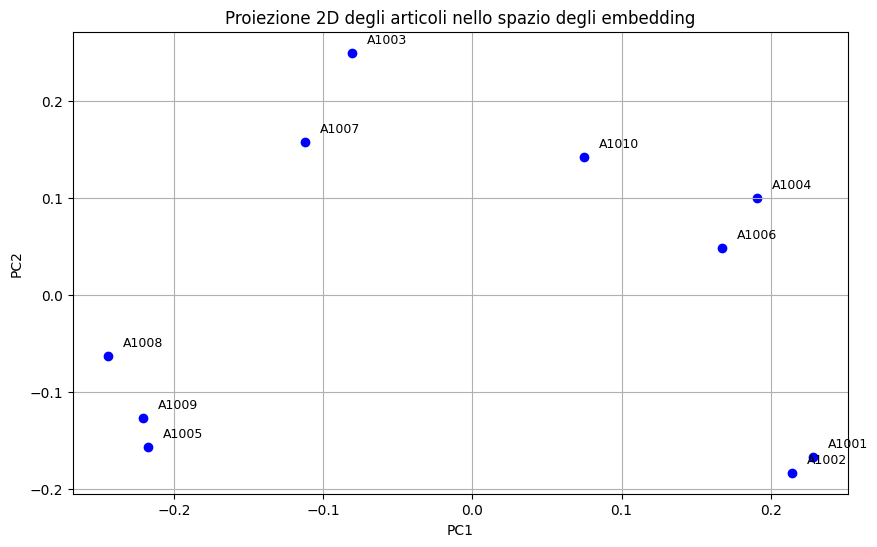

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embeddings_matrix)

plt.figure(figsize=(10, 6))
for i, row in df.iterrows():
    x, y = embedding_2d[i]
    plt.scatter(x, y, marker="o", color="blue")
    plt.text(x + 0.01, y + 0.01, row["codice"], fontsize=9)

plt.title("Proiezione 2D degli articoli nello spazio degli embedding")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

## Similarità tra vettori

Nel nostro modello, articoli simili hanno **vettori di embedding vicini** nello spazio.

Per misurare la similarità usiamo la **cosine similarity** (o, nel caso di FAISS L2, la distanza euclidea):
- Similarità alta = angolo piccolo → articoli semanticamente affini
- Similarità bassa = angolo grande → articoli diversi

Nell'immagine sopra, gli articoli vicini tra loro sono considerati alternative plausibili.

In [28]:
def raccomanda_simili(codice_articolo: str, top_n: int = 5):
    articolo = df[df["codice"] == codice_articolo]
    if articolo.empty:
        raise ValueError("Codice articolo non trovato")

    query_embedding = np.array(articolo["embedding"].iloc[0]).reshape(1, -1)
    distanze, indici = index.search(query_embedding, top_n + 1)

    risultati = df.iloc[indici[0]]
    risultati["similarità"] = np.exp(-distanze[0])
    risultati = risultati[risultati["codice"] != codice_articolo]
    return risultati[["codice", "descrizione", "categoria", "similarità"]].sort_values(
        by="similarità", ascending=False
    )

In [29]:
raccomanda_simili("A1001", top_n=3)

,codice,descrizione,categoria,similarità
1,A1002,Valvola in ottone da 1 pollice,valvole,0.929537
5,A1006,Valvola regolatrice in acciaio per alta pressione,valvole,0.807916
3,A1004,Valvola a farfalla con leva manuale,valvole,0.772611


In [20]:
def mostra_simili_2d(codice_articolo: str, top_n: int = 5):
    articolo_idx = df.index[df["codice"] == codice_articolo].item()
    query_emb = embeddings_matrix[articolo_idx].reshape(1, -1)
    _, indici = index.search(query_emb, top_n + 1)

    plt.figure(figsize=(10, 6))
    for i in range(len(df)):
        x, y = embedding_2d[i]
        if i == articolo_idx:
            plt.scatter(
                x, y, marker="x", color="red", s=100, label="Articolo richiesto"
            )
        elif i in indici and i != articolo_idx:
            plt.scatter(
                x,
                y,
                marker="o",
                color="green",
                s=80,
                label="Simile"
                if "Simile" not in plt.gca().get_legend_handles_labels()[1]
                else "",
            )
        else:
            plt.scatter(x, y, marker="o", color="lightgray")

        plt.text(x + 0.01, y + 0.01, df.iloc[i]["codice"], fontsize=8)

    plt.title(f"Articolo '{codice_articolo}' e simili nello spazio 2D")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.show()

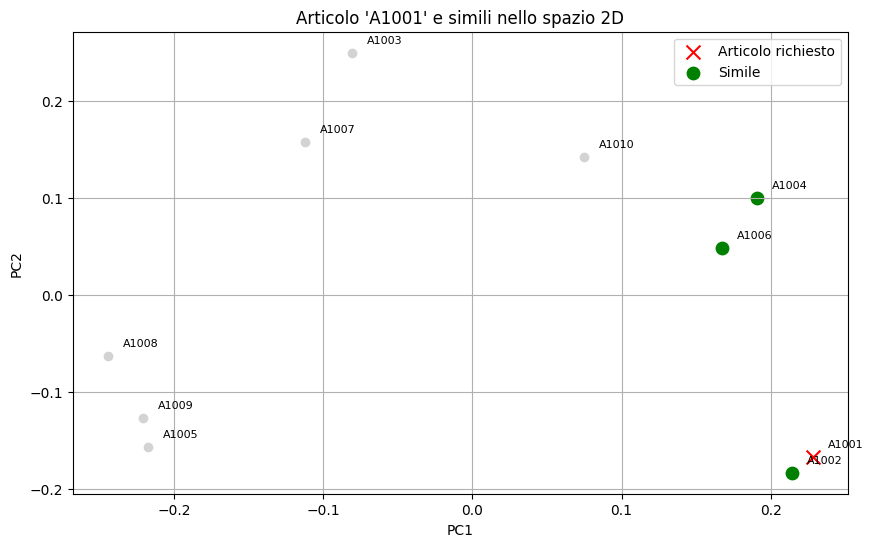

In [21]:
mostra_simili_2d("A1001", top_n=3)

# Conclusioni

Abbiamo costruito un sistema di recommendation che:

1. Usa **embedding semantici** di Azure OpenAI per rappresentare articoli come vettori numerici.
2. Indica articoli simili cercandoli in uno spazio vettoriale con **FAISS**.
3. Mostra un'alternativa moderna a TF-IDF e keyword matching, capace di cogliere la **semantica**.

## Estensioni possibili:
- Salvataggio e caricamento dell’indice FAISS su disco
- Uso di un vector database esterno (Pinecone, Qdrant)
- Aggiunta di filtri strutturali (categoria, disponibilità, ecc.)
- Calcolo di embedding offline (batch) e salvataggio in database

---